In [ ]:
! pip install qiskit

KMEANSアルゴリズムの量子コンピュータ実装<br>
* 振幅符号化を使った実装サンプルコード


In [2]:
# qiskit import
from qiskit import *
from qiskit.tools.visualization import *
from qiskit.quantum_info import state_fidelity, process_fidelity

# 必要なライブラリをimportする
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
import seaborn as sns
import copy
import math
import os


Ｋ平均法でのirisデータクラスタリング
①古典のみ実装
②量子・古典のハイブリッド実装

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'label'],
      dtype='object')
   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  label
0                5.1               3.5  ...               0.2      0
1                4.9               3.0  ...               0.2      0
2                4.7               3.2  ...               0.2      0
3                4.6               3.1  ...               0.2      0
4                5.0               3.6  ...               0.2      0
5                5.4               3.9  ...               0.4      0
6                4.6               3.4  ...               0.3      0
7                5.0               3.4  ...               0.2      0
8                4.4               2.9  ...               0.2      0
9                4.9               3.1  ...               0.1      0

[10 rows x 5 columns]
       sepal length (cm)  sepal width (cm)  ...  petal width (cm)       label
count       

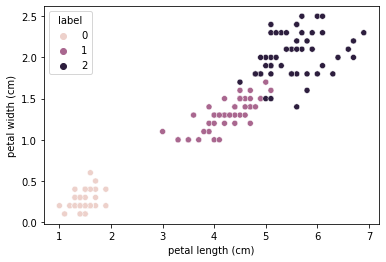

In [3]:
# irisデータセットを読み込み
iris = datasets.load_iris()       # irisを読み込む関数
df = pd.DataFrame(        
    iris.data,                    # データフレームの要素
    columns = iris.feature_names  # 各列の名前に特徴名を使う
)
df["label"] = iris.target         # わかりやすくするためにlabel列を追加
 
print(df.columns)                 #  カラムの表示
print(df.head(10))                #　最初の10行表示　　最後のデータはtail
print(df.describe())              # データフレーム要約統計量

# データ可視化
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# x=df['sepal length (cm)']
# y=df['petal length (cm)']
# z=df['petal width (cm)']
# l=df['label']
# ax.scatter(x, y, z, s = 40, c=l)
# plt.show()

sns.scatterplot(x='petal length (cm)', y='petal width (cm)',hue='label', data=df)  #　データ可視化

主成分分析により使用する項目の決定・次元削減

In [4]:
# PCA実行実行：２次元
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(df.iloc[:,0:4])
pca_iris = pca.transform(df.iloc[:,0:4])
pca_iris_df = pd.DataFrame(pca_iris,columns=['pca1','pca2'])

# PCA実行：３次元
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3).fit(df.iloc[:,0:4])
# pca_iris = pca.transform(df.iloc[:,0:4])
# pca_iris_df = pd.DataFrame(pca_iris,columns=['pca1','pca2','pca3'])

In [5]:
print('--- 寄与率 ----')
print(pca.explained_variance_ratio_)

--- 寄与率 ----
[0.92461872 0.05306648]


--- 主成分可視化　---
Index(['pca1', 'pca2', 'label'], dtype='object')
       pca1      pca2  label
0 -2.684126  0.319397      0
1 -2.714142 -0.177001      0
2 -2.888991 -0.144949      0
3 -2.745343 -0.318299      0
4 -2.728717  0.326755      0
5 -2.280860  0.741330      0
6 -2.820538 -0.089461      0
7 -2.626145  0.163385      0
8 -2.886383 -0.578312      0
9 -2.672756 -0.113774      0
               pca1          pca2       label
count  1.500000e+02  1.500000e+02  150.000000
mean  -2.667496e-15 -8.829974e-16    1.000000
std    2.056269e+00  4.926162e-01    0.819232
min   -3.223804e+00 -1.265971e+00    0.000000
25%   -2.530348e+00 -3.254152e-01    0.000000
50%    5.546193e-01 -2.215678e-02    1.000000
75%    1.550143e+00  3.249152e-01    2.000000
max    3.795645e+00  1.374165e+00    2.000000


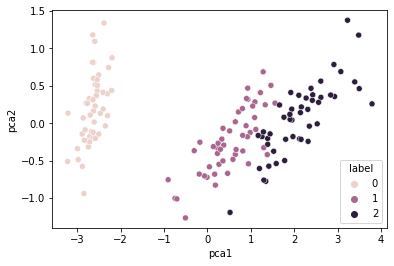

In [6]:
# label項目を追加
pca_iris_df["label"] = iris.target 

# データ統計表示
print('--- 主成分可視化　---')
print(pca_iris_df.columns)                 #  カラムの表示
print(pca_iris_df.head(10))                #　最初の10行表示　　最後のデータはtail
print(pca_iris_df.describe())              # データフレーム要約統計量

# 主成分をプロットする 2次元平面プロット
sns.scatterplot(x='pca1', y='pca2', hue='label', data=pca_iris_df)

# 主成分をプロットする 3次元プロット
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.set_xlabel("pca1")
# ax.set_ylabel("pca2")
# ax.set_zlabel("pca3")
# x=pca_iris_df['pca1']
# y=pca_iris_df['pca2']
# z=pca_iris_df['pca3']
# l=pca_iris_df['label']
# ax.scatter(x, y, z, s = 40, c=l)
# plt.show()

In [ ]:
#  0-1に正規化する
from sklearn import preprocessing
mm = preprocessing.MinMaxScaler()

# pcaデータをnumpyにnumpyに変換
nd_iris = pca_iris_df[['pca1','pca2']].to_numpy(copy=True)
nd_iris_min_max = mm.fit_transform(nd_iris)
print(nd_iris_min_max )

amp_def: データを振幅値に変換

In [8]:
def amp_def(X):
  X_size,X_features = X.shape
  # 出力用配列の初期化
  amp_X = np.zeros((X_size, X_features),dtype=np.float64)
  # 入力配列を振幅値に変換する
  for i in range(X_size):
    if np.sum(X[i,:]) == 0:
      X[i,:] += 1
    amp_X[i,:] = X[i,:] / math.sqrt(np.sum(X[i,:] ** 2)) 
  return amp_X

符号化した量子ビットのstateの一致度で判定するQMEANS

In [9]:
# Quantum means処理の定義  ：Fidelityで判別する
def qmeans_amp_F(k,X,shots=1000,max_iter=1000,v=0.05):
  X_size,n_features = X.shape
  # 初期値を平均と分散から決定する
  # mean = np.mean(X, axis = 0)
  # std = np.std(X, axis = 0)
  # centroids  = np.random.randn(k,n_features)*std + mean
  for i in range(k):
      if i > 0:
          centroids = np.append(centroids,X[np.random.choice(X_size,1,replace=False),:],axis=0)
      else:
          centroids = X[np.random.choice(X_size,1,replace=False),:]
  # 入力配列を振幅値へ変換
  X_amp = amp_def(X)
  centroids_amp = amp_def(centroids)
  # 中心点比較用の配列準備
  new_centroids = np.zeros((k, n_features))
  # クラスターラベル配列準備
  label_c = np.zeros(X_size)
  # ループ上限回数まで繰り返し
  for epoch in range(max_iter):
      #  print("epoch=",epoch)     # for debug
      for e in range(X_size):
        # Input data の符号化とstate取得
        q0 = QuantumRegister(1)        
        qc0 = QuantumCircuit(q0)
        initial_state_q0 = X_amp[e,:]
        qc0.initialize(initial_state_q0, 0)
        backend = BasicAer.get_backend('statevector_simulator')
        job0 = backend.run(transpile(qc0, backend))
        qc_state0 = job0.result().get_statevector(qc0)
        # print(qc_state0) 
        f_dim = np.zeros(k)
        # cluster=0 との比較
        initial_state_q1 = centroids_amp[0,:]
        q1 = QuantumRegister(1)
        qc1 = QuantumCircuit(q1)
        qc1.initialize(initial_state_q1, 0)
        job1 = backend.run(transpile(qc1, backend))
        qc_state1 = job1.result().get_statevector(qc1)    
        # print(qc_state1)
        f_dim[0] = state_fidelity(qc_state0, qc_state1)
        # cluster=1 との比較
        initial_state_q2 = centroids_amp[1,:]
        q2 = QuantumRegister(1)
        qc2 = QuantumCircuit(q2)
        qc2.initialize(initial_state_q2, 0)
        job2 = backend.run(transpile(qc2, backend))
        qc_state2 = job2.result().get_statevector(qc2)    
        # print(qc_state2)
        f_dim[1] = state_fidelity(qc_state0, qc_state2)
        # cluster=2 との比較
        initial_state_q3 = centroids_amp[2,:]
        q3 = QuantumRegister(1)
        qc3 = QuantumCircuit(q3)
        qc3.initialize(initial_state_q3, 0)
        job3 = backend.run(transpile(qc3, backend))
        qc_state3 = job3.result().get_statevector(qc3)    
        # print(qc_state3)
        f_dim[2] = state_fidelity(qc_state0, qc_state3)
        # fedelity state の最大値インデックスをlabelにする
        label_c[e] = np.argmax(f_dim)
        df_s = pd.DataFrame(f_dim,columns=['fedelity'])
        df_s.to_csv('../content/data/swaptest.csv',mode='a')

      # 新しい中心点を算出
      for j in range(k):
           new_centroids[j] = X[label_c==j,:].mean(axis=0)
      # print("centroids=",centroids)
      # print("new centroids=",new_centroids)
      # 欠損値は平均に置き換え
      new_centroids = np.nan_to_num(new_centroids, np.nanmean(X))
      error = np.linalg.norm(new_centroids - centroids)
      print("centroids deff =", error, file=myfile)
      # 中心点の変化が変数vより小さければ終了
      if float(error) < float(v) :
           print("break")
           break
      df_c = pd.DataFrame(centroids,columns=['c1','c2'])
      df_c.to_csv('../content/data/centroids_hist.csv',mode='a')
      centroids =  copy.copy(new_centroids)
      centroids_amp = amp_def(centroids)
      print("new_centroids=",centroids_amp)
  return label_c,centroids_amp

PCA後の古典ベクトル配列を振幅に変換（L2正則化されている）

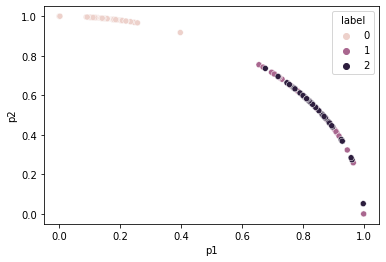

In [10]:
# print(pca_iris)
# iris_amp = amp_def(np_iris_x)     PCA分析ではない
iris_amp = amp_def(nd_iris_min_max)
# iris_amp = amp_def(pca_iris)
# print(pca_iris_amp)

# 振幅値データの可視化
iris_amp_df_s = pd.DataFrame(iris_amp,columns=['p1','p2'])
iris_amp_df_s["label"] = iris.target 
sns.scatterplot(x='p1', y='p2', hue='label', data=iris_amp_df_s)

In [11]:
# ログファイルの前処理
import os
os.makedirs('../content/data', exist_ok=True)
if os.path.exists('../content/data/swaptest.csv') == True:
  os.remove('../content/data/swaptest.csv')
if os.path.exists('../content/data/centroids_hist.csv') == True:
  os.remove('../content/data/centroids_hist.csv')
if os.path.exists('../content/data/nd_iris_scale.txt') == True:
  os.remove('../content/data/nd_iris_scale.txt')
np.savetxt('../content/data/nd_iris_scale.txt', iris_amp)

# ログファイルのオープン
myfile = open("../content/data/sysout.txt", "w")

# qmeans実行
label_c,centroids_amp=qmeans_amp_F(3,iris_amp,shots=1000,max_iter=10,v=0.05)

# ログファイルのクローズ
myfile.close()

new_centroids= [[0.93704972 0.34919596]
 [0.15452578 0.98798876]
 [0.80185981 0.59751221]]
break


         X1        X2  label_c
0  0.937050  0.349196        0
1  0.154526  0.987989        1
2  0.801860  0.597512        2
         p1        p2  label  label_c
0  0.126998  0.991903      0      1.0
1  0.173366  0.984858      0      1.0
2  0.111632  0.993750      0      1.0
3  0.186560  0.982444      0      1.0
4  0.116122  0.993235      0      1.0
5  0.173989  0.984748      0      1.0
6  0.127862  0.991792      0      1.0
7  0.155357  0.987858      0      1.0
8  0.181489  0.983393      0      1.0
9  0.177040  0.984204      0      1.0


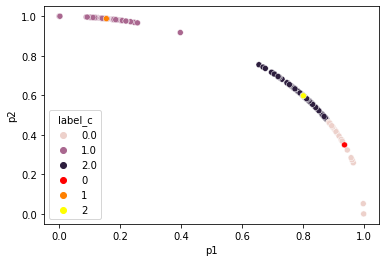

In [12]:
# 中心点配列をdataframeに変換
centroids_amp_df = pd.DataFrame(centroids_amp,columns=['X1','X2'])
label_X = [0,1,2]
centroids_amp_df['label_c'] = label_X
print(centroids_amp_df)

# クラスタリング結果の可視化 
df_cluster = pd.DataFrame(label_c,columns=['label_c'])
df_plot = pd.concat([iris_amp_df_s,df_cluster],axis=1)

df_plot.to_csv('../content/data/clusterd_data.csv',mode='w')
print(df_plot.head(10)) 

# クラスタリング結果を可視化する: ２次元
sns.scatterplot(x='p1', y='p2', hue='label_c', data=df_plot)
sns.scatterplot(x='X1', y='X2', hue='label_c', palette='autumn', markers='*', data=centroids_amp_df)


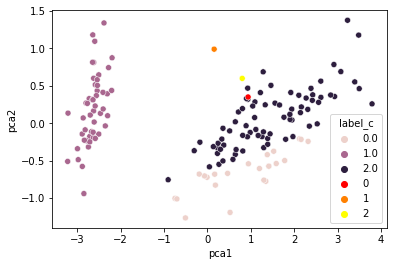

In [15]:
# PCAデータで可視化
df_plot = pd.concat([pca_iris_df,df_cluster],axis=1)

# クラスタリング結果を可視化する: ２次元
sns.scatterplot(x='pca1', y='pca2', hue='label_c', data=df_plot)
sns.scatterplot(x='X1', y='X2', hue='label_c', palette='autumn', markers='*', data=centroids_amp_df)